In [1]:
# mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/12746-Project/CamVid

/content/drive/MyDrive/12746-Project/CamVid


In [3]:
# Common
import os 
import keras
import pandas as pd
import numpy as np
from tqdm import tqdm 
import tensorflow as tf


# Data 
import tensorflow.image as tfi
from tensorflow.keras.utils import Sequence
#from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
# Data Viz
import plotly.express as px
import matplotlib.pyplot as plt

# Model
from keras.models import Model
from keras.layers import Input
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import MaxPool2D
from keras.layers import concatenate as c_
from keras.layers import ReLU


# Callbacks
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [4]:
def load_data(directory_im,directory_mask,size_h,size_w):
  list_names_im=os.listdir(directory_im)
  list_names_mk=os.listdir(directory_mask)
  list_names_im.sort()
  list_names_mk.sort()
  
  array_images=[]
  array_masks=[]
  for i in tqdm(range(len(list_names_im))):
  
    # Load images
    img = image.load_img(directory_im+list_names_im[i])
    img = image.img_to_array(img)
    img = tfi.resize(img, (size_h, size_w))/255
    # Load masks
    mask = image.img_to_array(image.load_img(directory_mask+list_names_mk[i]))
    mask = tfi.resize(mask, (size_h, size_w))/255
    # Save images
    array_images.append(img)
    array_masks.append(mask)
  return array_images,array_masks


In [ ]:
list_names_im=os.listdir('train/')
list_names_mk=os.listdir('train_labels/')
list_names_im.sort()
list_names_mk.sort()

In [5]:
train_image_names,train_mask_names=load_data('train/','train_labels/',256,256)
val_image_names,val_mask_names=load_data('val/','val_labels/',256,256)
test_image_names,test_mask_names=load_data('test/','test_labels/',256,256)

100%|██████████| 232/232 [01:57<00:00,  1.97it/s]


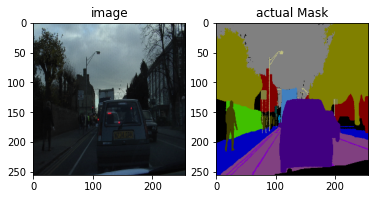

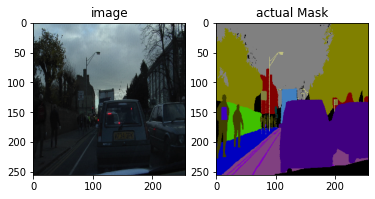

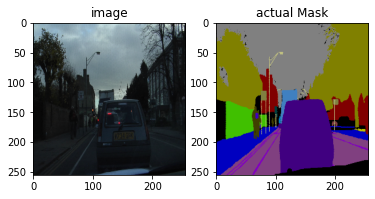

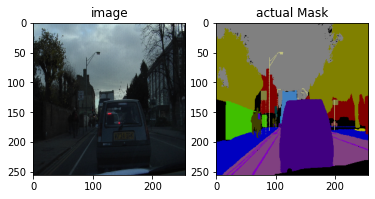

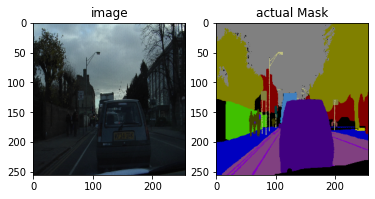

In [6]:
img=train_image_names[0:5]
label=train_mask_names[0:5]
for i in range(len(img)):
  
  plt.subplot(1,2,1)
  
  plt.imshow(img[i])
  plt.title('image')
  plt.subplot(1,2,2)
  plt.imshow(label[i])
  plt.title('actual Mask')
  plt.show()

In [ ]:
df=pd.read_csv("class_dict.csv")
id_label={}
id_code={}
for i in range(len(df)):
  #print(df.loc[i,:])
  #print(df.loc[i,:]['name'])
  #print((df.loc[i,:]['r'],df.loc[i,:]['b'],df.loc[i,:]['g']))
  id_label[i]=df.loc[i,:]['name']
  id_code[i]=(df.loc[i,:]['r'],df.loc[i,:]['g'],df.loc[i,:]['b'])

print(len(df))

32


In [7]:
def encoder_individual_model(input_layer,filter_size,num_filter,dropout=0.1):
  conv1 = tf.keras.layers.Conv2D(filter_size * num_filter, (3, 3), kernel_initializer = 'he_normal', padding = 'same')(input_layer)
  batch1 = tf.keras.layers.BatchNormalization()(conv1)
  relu1 =tf.keras.layers.Activation('relu')(batch1)
  conv2 = tf.keras.layers.Conv2D(filter_size * num_filter, (3, 3), kernel_initializer = 'he_normal', padding = 'same') (relu1)
  batch2 = tf.keras.layers.BatchNormalization()(conv2)
  relu2 =tf.keras.layers.Activation('relu')(batch2)
  pool1 = tf.keras.layers.MaxPooling2D((2, 2))(relu2)
  drop1 = tf.keras.layers.Dropout(dropout)(pool1) 
  return drop1,relu2

In [8]:
def decoder_individual_model(input_layer,concat_layer,filter_size,num_filter,dropout=0.1):
  deconv1 = tf.keras.layers.Conv2DTranspose(filter_size * num_filter, (3, 3), strides=(2, 2), padding="same")(input_layer)

  uconv1 = tf.keras.layers.concatenate([deconv1, concat_layer])
  drop1 = tf.keras.layers.Dropout(dropout)(uconv1)

  conv1 = tf.keras.layers.Conv2D(filter_size * num_filter, (3, 3), kernel_initializer = 'he_normal', padding = 'same')(drop1)
  batch1 = tf.keras.layers.BatchNormalization()(conv1)
  relu1 =tf.keras.layers.Activation('relu')(batch1)
  conv2 = tf.keras.layers.Conv2D(filter_size * num_filter, (3, 3), kernel_initializer = 'he_normal', padding = 'same') (relu1)
  batch2 = tf.keras.layers.BatchNormalization()(conv2)
  relu2 =tf.keras.layers.Activation('relu')(batch2)
  return relu2

In [9]:
def UNet_model(input_image,dropout=0.1):
  ##Encoder architecture
  fif=16
  output_layer1,conv_output1=encoder_individual_model(input_image,fif,1,dropout)
  output_layer2,conv_output2=encoder_individual_model(output_layer1,fif,2,dropout)
  output_layer3,conv_output3=encoder_individual_model(output_layer2,fif,4,dropout)
  output_layer4,conv_output4=encoder_individual_model(output_layer3,fif,8,dropout)
  #Middle Convolution
  convm1 = tf.keras.layers.Conv2D(fif * 16, (3, 3), kernel_initializer = 'he_normal', padding = 'same')(output_layer4)
  batchm1 = tf.keras.layers.BatchNormalization()(convm1)
  relum1 =tf.keras.layers.Activation('relu')(batchm1)
  convm2 = tf.keras.layers.Conv2D(fif * 16, (3, 3), kernel_initializer = 'he_normal', padding = 'same') (relum1)
  batchm2 = tf.keras.layers.BatchNormalization()(convm2)
  relum2 =tf.keras.layers.Activation('relu')(batchm2)
  #decorder Architecture
  decode_layer4=decoder_individual_model(relum2,conv_output4,fif,8,dropout)
  decode_layer3=decoder_individual_model(decode_layer4,conv_output3,fif,4,dropout)
  decode_layer2=decoder_individual_model(decode_layer3,conv_output2,fif,2,dropout)
  decode_layer1=decoder_individual_model(decode_layer2,conv_output1,fif,1,dropout)
  #Output Convolution
  output = Conv2D(3, (1, 1), activation='sigmoid') (decode_layer1)
  model = Model(inputs=[input_image], outputs=[output])
  return model


In [10]:
input_img = tf.keras.layers.Input(shape=(256, 256, 3))
transformer_model = UNet_model(input_img, 0.05)
transformer_model.compile(optimizer='Adam', loss="binary_crossentropy", metrics=["accuracy",keras.metrics.MeanIoU(num_classes=32, name="IoU")])

In [11]:
transformer_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [13]:
results = transformer_model.fit(np.array(train_image_names), np.array(train_mask_names), epochs=100,batch_size=10,validation_data=(np.array(val_image_names), np.array(val_mask_names)))

Epoch 1/100
37/37 [==============================] - 9s 246ms/step - loss: 0.6806 - accuracy: 0.6345 - IoU: 0.5000 - val_loss: 77.6363 - val_accuracy: 0.5745 - val_IoU: 0.2787
Epoch 2/100
37/37 [==============================] - 6s 150ms/step - loss: 0.6264 - accuracy: 0.7566 - IoU: 0.5000 - val_loss: 1.3440 - val_accuracy: 0.6176 - val_IoU: 1.0000
Epoch 3/100
37/37 [==============================] - 5s 148ms/step - loss: 0.6131 - accuracy: 0.7420 - IoU: 1.0000 - val_loss: 0.6425 - val_accuracy: 0.8273 - val_IoU: 1.0000
Epoch 4/100
37/37 [==============================] - 5s 148ms/step - loss: 0.6022 - accuracy: 0.7373 - IoU: 1.0000 - val_loss: 0.6287 - val_accuracy: 0.8318 - val_IoU: 1.0000
Epoch 5/100
37/37 [==============================] - 6s 154ms/step - loss: 0.5845 - accuracy: 0.6221 - IoU: 1.0000 - val_loss: 0.6246 - val_accuracy: 0.5491 - val_IoU: 1.0000
Epoch 6/100
37/37 [==============================] - 6s 152ms/step - loss: 0.5714 - accuracy: 0.5244 - IoU: 1.0000 - val_los

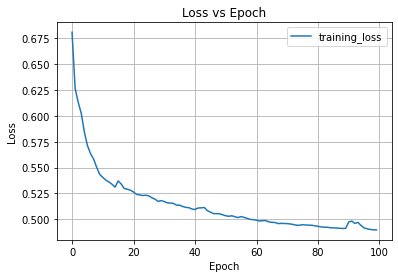

In [15]:
plt.plot(results.history['loss'], label = 'training_loss')
plt.title("Loss vs Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

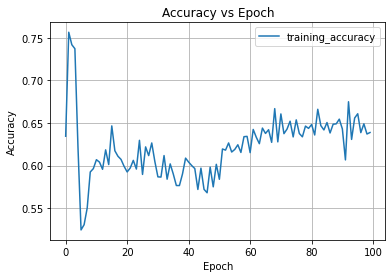

In [16]:
plt.plot(results.history['accuracy'], label = 'training_accuracy')
plt.title("Accuracy vs Epoch")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [22]:

def prediction(img,mask, model, shape = 256):
    ## getting and proccessing val data
    mask = mask[:5]   
    imgProc = img[:5]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
    
    return predictions, imgProc, mask
    

    
    
def plot_result(img, predMask, groundTruth):
    plt.figure(figsize=(10,10))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Mask')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('actual Mask')

In [19]:
import cv2 
val_predict, val_img, val_mask = prediction(np.array(val_image_names), np.array(val_mask_names), transformer_model)
test_predict, test_img, test_mask = prediction(np.array(test_image_names), np.array(test_mask_names), transformer_model)

8/8 [==============================] - 2s 211ms/step


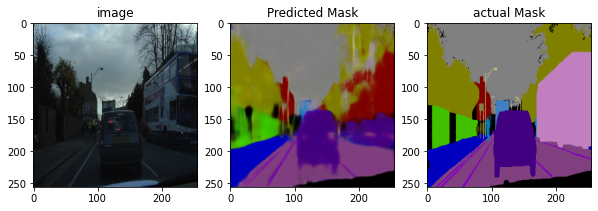

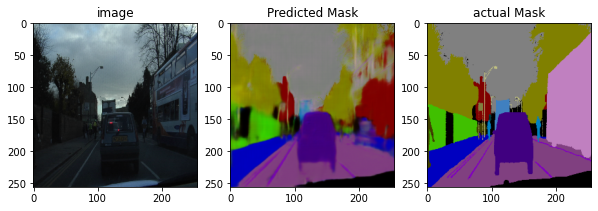

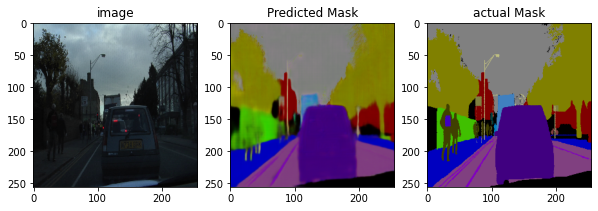

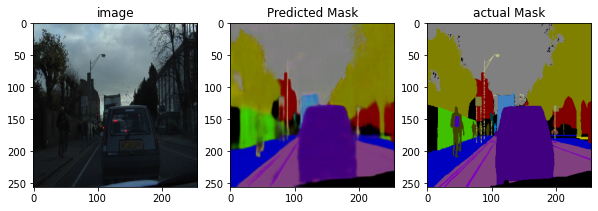

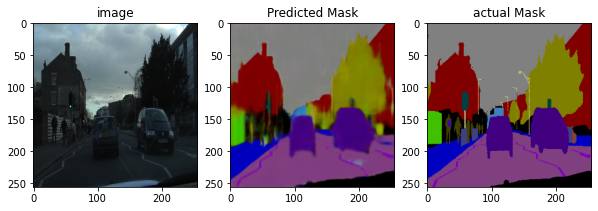

In [23]:
for i in range(5):
  plot_result(val_img[i], val_predict[i], val_mask[i])


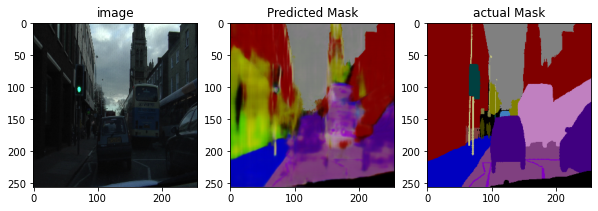

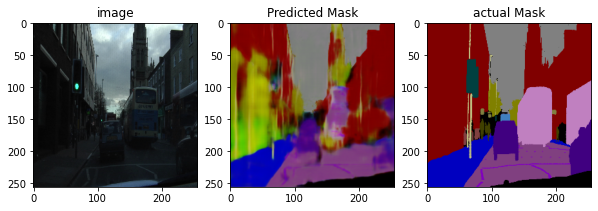

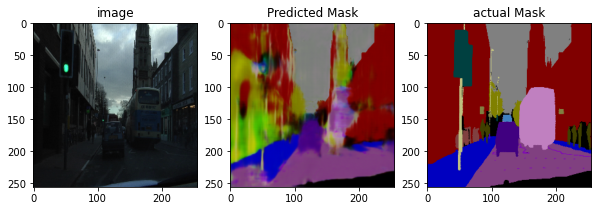

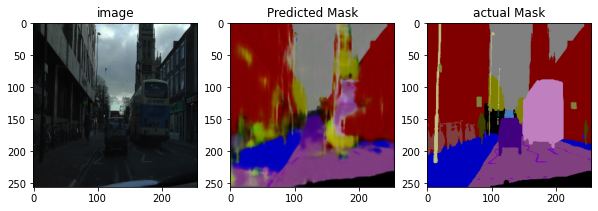

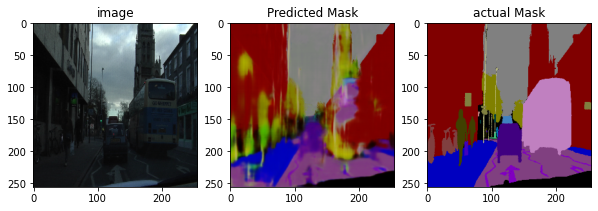

In [24]:
for i in range(5):
  plot_result(test_img[i], test_predict[i], test_mask[i])